In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time


### Step 1: Structural Simulator for Synthetic Data Generation

This cell generates a three-channel (GT/MT/EC) synthetic dataset for training a constrained policy that imitates game-theoretic equilibria.

**Purpose**
- Sample **interpretable market states** (elasticities, advertising spillovers, channel-specific trust, costs).
- Solve **near-Nash equilibria** per state and log **(state, action, outcome)** triplets for learning.

**Method**
- **Prices**: closed-form best response from the FOC, then **cost-relative clamping** (P_i in [1.05c_i,6.0c_i]).
- **Advertising**: 1D FOC solved by **bisection** with spillovers, constrained to (a_i in [0,20]).
- **Demand modifiers**: cross-price substitution, cross-channel ad spillovers, and a trust factor tau(T)= T^{p}/(T^{p}+theta^{p}).

**Reproducibility**
- Fixed seed: `SEED = 2025`.

**Outputs**
- Prints and writes output data to `/content/sim_multichannel_fast_relprice_10k.csv` for the following training and evaluation step.


In [ ]:
# ===========================
# 3-Channel Structural Simulator
# ===========================


SEED = 2025
rng = np.random.default_rng(SEED)
channels = ["GT","MT","EC"]
EPS = 1e-9
N_ROWS = 10_000

#
# Ranges for demand function parameter
R = {
    "alpha": (0.8, 1.2),
    "beta":  (0.8, 1.2),
    "gamma": (0.3, 0.7),   # for all ordered pairs i!=j
    "kappa": (0.8, 1.2),
    "psi":   (0.3, 0.7),
    "sigma": (0.3, 0.7),   # for all ordered pairs i!=j
    "chi":   (0.8, 1.5),
    "p":     (2.0, 6.0),
    "theta": (0.3, 0.7),
    "T":     (0.0, 1.0),
}
# Structured costs
CR = {"w":(0.6,1.2), "l":(0.1,0.6), "mu":(0.05,0.25)}

# Price bounds relative to cost
MARKUP_BOUNDS = (1.05, 6.0)   # P in [m_lo*c, m_hi*c]
A_BOUNDS = (0.0, 20.0)

u = lambda lo,hi: rng.uniform(lo,hi)
def tau(T,p,th,eps=1e-12):
    Tp = np.power(np.clip(T,0,1), p)
    return Tp/(Tp+th**p+eps)

def sample_env():
    # market params
    params = {k:{ch:u(*R[k]) for ch in channels} for k in ["alpha","beta","kappa","psi","chi","p","theta"]}
    T = u(*R["T"])
    # cross-effects
    gamma,sigma={},{}
    for i in channels:
        for j in channels:
            if i==j: continue
            gamma[(i,j)] = u(*R["gamma"])
            sigma[(i,j)] = u(*R["sigma"])
    # structured costs
    w = {ch:u(*CR["w"]) for ch in channels}
    l = {"GT":u(*CR["l"]), "MT":u(*CR["l"]), "EC":0.0}
    mu = {"GT":0.0, "MT":0.0, "EC":u(*CR["mu"])}
    c = {"GT":w["GT"]+l["GT"], "MT":w["MT"]+l["MT"], "EC": w["EC"]/max(1-mu["EC"],1e-6)}
    params["c"]=c
    return T, params, gamma, sigma, w, l, mu

def eta_i(i, beta, gamma):
    return beta[i] + sum(gamma[(i,j)] for j in channels if j!=i)

def price_star(i, params, gamma, m_bounds=MARKUP_BOUNDS):
    c_i = params["c"][i]
    eta = eta_i(i, params["beta"], gamma)
    # closed-form BR from FOC
    P = (eta/(eta-1.0))*c_i if eta>1.0+1e-8 else m_bounds[1]*c_i
    lo, hi = m_bounds[0]*c_i, m_bounds[1]*c_i
    P = float(np.clip(P, lo, hi))
    if P<=0: P = lo
    return P, lo, hi

def demand_const_base(i, P, T, params, gamma):
    alpha = params["alpha"][i]; p=params["p"][i]; th=params["theta"][i]
    eta = eta_i(i, params["beta"], gamma)
    Pi = max(P[i], EPS)
    prod = 1.0
    for j in channels:
        if j==i: continue
        prod *= max(P[j],EPS)**(gamma[(i,j)])
    return alpha * tau(T,p,th) * (Pi**(-eta)) * prod

def ad_best_response(i, P, a_all, T, params, gamma, sigma, iters=30):
    a_lo,a_hi = A_BOUNDS
    chi=params["chi"][i]; kappa=params["kappa"][i]; psi=params["psi"][i]
    c_i=params["c"][i]; margin=max(P[i]-c_i,0.0)
    if margin<=0 or psi<=0 or kappa<=0: return 0.0
    spill = 1.0 + sum(sigma[(i,j)]*a_all[j] for j in channels if j!=i)
    K = margin * demand_const_base(i,P,T,params,gamma) * spill
    def f(a): return K*psi*kappa*(1+kappa*a)**(psi-1.0) - a/chi
    lo,hi=a_lo,a_hi
    if f(lo)<=0: return 0.0
    if f(hi)>0:  return a_hi
    for _ in range(iters):
        mid=0.5*(lo+hi)
        if f(mid)>0: lo=mid
        else: hi=mid
    return float(0.5*(lo+hi))

def solve_equilibrium_fast(T, params, gamma, sigma):
    # P*
    P = {}; Plo={}; Phi={}
    for i in channels:
        P[i], Plo[i], Phi[i] = price_star(i, params, gamma)
    # a*
    a = {i:0.0 for i in channels}
    for _ in range(6):
        for i in channels:
            a[i] = np.clip(ad_best_response(i,P,a,T,params,gamma,sigma), *A_BOUNDS)
    return P,a,Plo,Phi

def simulate_one():
    T, params, gamma, sigma, w,l,mu = sample_env()
    P,a,Plo,Phi = solve_equilibrium_fast(T, params, gamma, sigma)

    # outcomes
    def Q_i(i):
        alpha=params["alpha"][i]; beta=params["beta"][i]
        kappa=params["kappa"][i]; psi=params["psi"][i]
        p=params["p"][i]; th=params["theta"][i]
        Pi=max(P[i],EPS); price_term=Pi**(-beta)
        cross=1.0
        for j in channels:
            if j==i: continue
            cross *= (max(P[j],EPS)/Pi)**(gamma[(i,j)])
        own=(1+kappa*a[i])**psi
        spill=1.0+sum(sigma[(i,j)]*a[j] for j in channels if j!=i)
        return max(alpha*price_term*cross*own*spill*tau(T,p,th), 0.0)

    Q = {i:Q_i(i) for i in channels}
    Prof = {i:(P[i]-params["c"][i])*Q[i] - (a[i]**2)/(2.0*params["chi"][i]) for i in channels}

    rec = {"T":T,
           **{f"Pstar_{i}":P[i] for i in channels},
           **{f"astar_{i}":a[i] for i in channels},
           **{f"Q_{i}":Q[i] for i in channels},
           **{f"Pi_{i}":Prof[i] for i in channels},
           "Pi_total": sum(Prof.values())}
    for key in ["alpha","beta","kappa","psi","chi","p","theta"]:
        for i in channels: rec[f"{key}_{i}"]=params[key][i]
    for i in channels:
        rec[f"w_{i}"]=w[i]; rec[f"c_{i}"]=params["c"][i]
    rec["l_GT"],rec["l_MT"],rec["l_EC"]=l["GT"],l["MT"],0.0
    rec["mu_GT"],rec["mu_MT"],rec["mu_EC"]=0.0,0.0,mu["EC"]
    for (i,j),v in gamma.items(): rec[f"gamma_{i}_{j}"]=v
    for (i,j),v in sigma.items(): rec[f"sigma_{i}_{j}"]=v
    # diagnostics: bounds actually used
    for i in channels: rec[f"Plo_{i}"]=Plo[i]; rec[f"Phi_{i}"]=Phi[i]
    return rec

rows=[simulate_one() for _ in range(N_ROWS)]
df=pd.DataFrame(rows)

# sanity: P* > 0 and inside relative bounds
for i in channels:
    assert (df[f"Pstar_{i}"]>0).all()
    assert (df[f"Pstar_{i}"]>=df[f"Plo_{i}"]-1e-8).all()
    assert (df[f"Pstar_{i}"]<=df[f"Phi_{i}"]+1e-8).all()

print(df.shape)
display(df.head(10))
out_path="/content/sim_multichannel_fast_relprice_10k.csv"
df.to_csv(out_path,index=False)
print("Saved:", out_path)


(10000, 65)


,T,Pstar_GT,Pstar_MT,Pstar_EC,astar_GT,astar_MT,astar_EC,Q_GT,Q_MT,Q_EC,...,sigma_MT_GT,sigma_MT_EC,sigma_EC_GT,sigma_EC_MT,Plo_GT,Phi_GT,Plo_MT,Phi_MT,Plo_EC,Phi_EC
0,0.579021,3.192873,2.818811,2.352365,0.141907,0.138418,0.437601,0.287792,0.269940,0.810868,...,0.494341,0.670604,0.612810,0.507049,1.688882,9.650753,1.664900,9.513715,1.132032,6.468755
1,0.140268,3.447110,2.047598,3.669944,0.000099,0.000116,0.000463,0.000090,0.000237,0.000243,...,0.492092,0.563130,0.333819,0.630078,1.806735,10.324198,1.077282,6.155900,1.564954,8.942594
2,0.239803,2.026385,3.072411,1.796174,0.042648,0.009213,0.089977,0.131783,0.015114,0.152593,...,0.558586,0.303585,0.480062,0.524713,1.231193,7.035389,1.595981,9.119894,1.024381,5.853604
3,0.065271,1.859960,2.127786,2.322371,0.000133,0.000395,0.000001,0.000318,0.000760,0.000003,...,0.683368,0.380229,0.623854,0.574292,1.046673,5.980989,1.297378,7.413588,1.238540,7.077373
4,0.583252,1.971153,1.801876,2.424366,0.197856,0.207713,0.116341,0.478465,0.787470,0.143822,...,0.698452,0.682597,0.346073,0.542890,1.003360,5.733483,0.971793,5.553103,1.226943,7.011102
5,0.283388,3.095539,2.387384,2.090217,0.018710,0.056372,0.010024,0.032940,0.061428,0.013375,...,0.666828,0.509443,0.446902,0.699091,1.241748,7.095705,1.250324,7.144711,1.211862,6.924925
6,0.350899,2.225891,2.323242,2.126503,0.100768,0.025331,0.085048,0.167247,0.043440,0.110520,...,0.305634,0.596879,0.519350,0.504511,1.341966,7.668375,1.222631,6.986460,1.078646,6.163692
7,0.712559,2.657432,2.966398,1.912881,0.237350,0.294477,0.509192,0.344575,0.371175,1.282452,...,0.629939,0.573088,0.643970,0.335270,1.442159,8.240910,1.348511,7.705778,0.901273,5.150129
8,0.138756,2.487732,3.022065,1.667809,0.009965,0.001979,0.011535,0.019468,0.002150,0.030973,...,0.682111,0.533940,0.633291,0.686469,1.340468,7.659815,1.693657,9.678042,0.869360,4.967770
9,0.986264,2.647928,2.363440,2.092412,0.469317,0.181082,0.300169,0.566159,0.446814,0.671937,...,0.333560,0.638792,0.442302,0.642569,1.313723,7.506988,1.272294,7.270253,1.155359,6.602049


Saved: /content/sim_multichannel_fast_relprice_10k.csv


### Step 2: Constrained Policy Learning and Evaluation

This cell trains and evaluates a **lightweight supervised policy** that imitates equilibrium outcomes generated by the above structural simulator.

**Purpose**
- Learn a mapping from **market state → equilibrium actions** ((P*, a*)).
- Enforce **feasibility constraints** at inference: P_i in [1.05 c_i,6.0 c_i], a_i in [0,20].
- Quantify performance using **prediction error** (RMSE) and **economic quality** metrics.
- Quantify efficiency using **runtime** and ensure equilibrium logic through **sensitivy analysis**.

**Method**
1. Load synthetic equilibria data, extract feature matrix (X) (state variables) and target vector (y) (actions).  
2. **Split** into train/validation/test (80/10/10).  
3. **Scale features**; targets left unscaled since they are bounded by costs.  
4. **Model** two-layer MLP \((256,128)\), ReLU activations, Adam optimizer.  
5. **Apply clipping** to guarantee outputs respect cost-relative and practical bounds.  

**Evaluation**
- **Action RMSE**: prediction accuracy per action.  
- **Economic metrics**: calculate outcomes from predicted actions and compare with true equilibria, reporting:  
  - Ratio of Means, Trimmed Ratio (5–95%), Mean Regret, Average Profit Gap.  
  - Profit gap distribution and negative-profit share.  
- **Sensitivy analysis**: analyse the changes of predicted P and a when Trust changes, to check if the policy holds economic logic from the structural simulator.
- **Runtime:** compare runtime between equlibrium solver and the trained policy.

**Outputs**
- RMSE table for prices/ads across GT/MT/EC.  
- Robust profit-based metrics confirming near-optimal performance.  
- Optional sample table comparing true vs. predicted actions on the test set.
- Visual chart for P and a with Trust
- Table for runtime of equlibrium solver vs. the trained policy


In [ ]:
# =========================================
# Train policy (supervised) to predict (P*, a*) from market state
# - Use data from CSV created above
# - Enforces action constraints at inference
# - Evaluates by RMSE and robust economic metrics
# =========================================


# ---- 1) Load dataset
csv_path = "/content/sim_multichannel_fast_relprice_10k.csv"
df = pd.read_csv(csv_path)

channels = ["GT","MT","EC"]
action_cols  = [f"Pstar_{ch}" for ch in channels] + [f"astar_{ch}" for ch in channels]
outcome_cols = [f"Q_{ch}" for ch in channels] + [f"Pi_{ch}" for ch in channels] + ["Pi_total"]

# ---- 2) Build features and target
feat_prefixes = ["alpha_","beta_","kappa_","psi_","chi_","p_","theta_",
                 "w_","l_","mu_","c_","gamma_","sigma_"]
feature_cols = ["T"] + [c for c in df.columns if any(c.startswith(p) for p in feat_prefixes)]
X = df[feature_cols].values
y = df[action_cols].values  # [P*_GT, P*_MT, P*_EC, a*_GT, a*_MT, a*_EC]

# ---- 3) Train/Val/Test split
X_train, X_tmp, y_train, y_tmp, df_train, df_tmp = train_test_split(X, y, df, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, df_val, df_test    = train_test_split( X_tmp, y_tmp, df_tmp, test_size=0.5, random_state=42)

# ---- 4) Scale features (except targets due to bound)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ---- 5) Model: lightweight MLP
model = MLPRegressor(
    hidden_layer_sizes=(256,128),
    activation="relu",
    solver="adam",
    learning_rate_init=3e-4,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)
model.fit(X_train_s, y_train)

# ---- 6) Inference + constraints
def clip_actions(df_block, Y_pred):
    """
    Enforce constraints:
    - P_i in [m_lo * c_i, m_hi * c_i], m_lo=1.05, m_hi=6.0
    - a_i in [0, 20]
    """
    m_lo, m_hi = 1.05, 6.0
    Yc = Y_pred.copy()
    for r in range(Yc.shape[0]):
        # per-row costs
        c_GT = df_block.iloc[r]["c_GT"]
        c_MT = df_block.iloc[r]["c_MT"]
        c_EC = df_block.iloc[r]["c_EC"]
        P_lo = np.array([m_lo*c_GT, m_lo*c_MT, m_lo*c_EC])
        P_hi = np.array([m_hi*c_GT, m_hi*c_MT, m_hi*c_EC])
        # prices: indices 0,1,2
        Yc[r,0:3] = np.clip(Yc[r,0:3], P_lo, P_hi)
        # ads: indices 3,4,5
        Yc[r,3:6] = np.clip(Yc[r,3:6], 0.0, 20.0)
    return Yc

def predict_with_constraints(Xs, df_block):
    raw = model.predict(Xs)
    return clip_actions(df_block, raw)

y_val_pred  = predict_with_constraints(X_val_s,  df_val)
y_test_pred = predict_with_constraints(X_test_s, df_test)

# ---- 7) RMSE for each action
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

rmse_vals = {col: rmse(y_test[:,i], y_test_pred[:,i]) for i,col in enumerate(action_cols)}
print("RMSE per action (test):")
for k,v in rmse_vals.items():
    print(f"  {k:>10s}: {v:.4f}")

# ---- 8) Economic evaluation: profit with predicted actions vs. optimal actions
EPS = 1e-9
def tau(T,p,th,eps=1e-12):
    Tp = np.power(np.clip(T,0,1), p)
    return Tp/(Tp+th**p+eps)

def eval_outcomes_row(row, P_hat, a_hat):
    chs = ["GT","MT","EC"]
    P = {ch: float(P_hat[i]) for i,ch in enumerate(chs)}
    a = {ch: float(a_hat[i]) for i,ch in enumerate(chs)}
    alpha={ch:row[f"alpha_{ch}"] for ch in chs}
    beta ={ch:row[f"beta_{ch}"]  for ch in chs}
    kappa={ch:row[f"kappa_{ch}"] for ch in chs}
    psi  ={ch:row[f"psi_{ch}"]   for ch in chs}
    chi  ={ch:row[f"chi_{ch}"]   for ch in chs}
    pshp ={ch:row[f"p_{ch}"]     for ch in chs}
    th   ={ch:row[f"theta_{ch}"] for ch in chs}
    c    ={ch:row[f"c_{ch}"]     for ch in chs}
    T    = row["T"]
    gamma={(i,j):row[f"gamma_{i}_{j}"] for i in chs for j in chs if i!=j}
    sigma={(i,j):row[f"sigma_{i}_{j}"] for i in chs for j in chs if i!=j}

    Q, Pi = {}, {}
    for i in chs:
        Pi_i = max(P[i], EPS)
        price_term = Pi_i ** (-beta[i])
        cross = 1.0
        for j in chs:
            if j==i: continue
            cross *= (max(P[j],EPS)/Pi_i) ** (gamma[(i,j)])
        own   = (1.0 + kappa[i]*a[i]) ** psi[i]
        spill = 1.0 + sum(sigma[(i,j)]*a[j] for j in chs if j!=i)
        trust = tau(T, pshp[i], th[i])
        Q[i]  = max(alpha[i]*price_term*cross*own*spill*trust, 0.0)
        Pi[i] = (P[i]-c[i])*Q[i] - (a[i]**2)/(2.0*chi[i])
    return Q, Pi

# Align indices with predictions
df_test_r = df_test.reset_index(drop=True)
pi_opt  = df_test_r["Pi_total"].to_numpy()
pi_pred = np.empty(len(df_test_r))

for r, row in df_test_r.iterrows():
    P_hat = y_test_pred[r, 0:3]
    a_hat = y_test_pred[r, 3:6]
    _, Pi = eval_outcomes_row(row, P_hat, a_hat)
    pi_pred[r] = sum(Pi.values())

# Robust metrics
eps = 1e-6
ratio_of_means = float(np.sum(pi_pred) / max(np.sum(pi_opt), eps))

mask = np.abs(pi_opt) > 1e-3  # avoid division by values ~0
ratios = pi_pred[mask] / pi_opt[mask]
lo, hi = np.percentile(ratios, [5, 95]) if ratios.size > 0 else (np.nan, np.nan)
ratio_trimmed = float(np.mean(ratios[(ratios>=lo) & (ratios<=hi)])) if ratios.size > 0 else np.nan
mean_regret_pct = float(np.mean((pi_opt[mask] - pi_pred[mask]) / np.maximum(np.abs(pi_opt[mask]), eps))) if ratios.size > 0 else np.nan

gap = pi_opt - pi_pred
gap_pcts = np.percentile(gap, [5, 25, 50, 75, 95])
share_neg_opt  = float(np.mean(pi_opt < 0))
share_neg_pred = float(np.mean(pi_pred < 0))

print(f"\nEconomic metrics (test):")
print(f"  Avg Profit Gap (opt - pred)         : {gap_mean:.4f}")
print(f"  Ratio of Means (robust)             : {ratio_of_means:.4f}  (≈1 is good)")
print(f"  Trimmed Ratio 5–95% (robust)        : {ratio_trimmed:.4f}")
print(f"  Mean Regret % over |Pi_opt|>1e-3    : {mean_regret_pct:.2%}")
print(f"  Profit Gap percentiles [5,25,50,75,95]: {gap_pcts}")
print(f"  Share negative profits (opt, pred)  : {share_neg_opt:.3f}, {share_neg_pred:.3f}")

# ---- 9) Table comparing true vs. predicted actions on test ----
cols = ["Pstar_GT","Pstar_MT","Pstar_EC","astar_GT","astar_MT","astar_EC"]
test_compare = pd.DataFrame(
    np.hstack([y_test, y_test_pred]),
    columns=[f"true_{c}" for c in cols] + [f"pred_{c}" for c in cols]
)
print("\nSample of true vs. predicted actions:")
print(test_compare.head(5))


RMSE per action (test):
    Pstar_GT: 0.0472
    Pstar_MT: 0.0471
    Pstar_EC: 0.0421
    astar_GT: 0.0214
    astar_MT: 0.0245
    astar_EC: 0.0309

Economic metrics (test):
  Avg Profit Gap (opt - pred)         : 0.0095
  Ratio of Means (robust)             : 1.0010  (≈1 is good)
  Trimmed Ratio 5–95% (robust)        : 0.9992
  Mean Regret % over |Pi_opt|>1e-3    : 0.40%
  Profit Gap percentiles [5,25,50,75,95]: [-6.04960606e-02 -8.73342946e-03  5.34269991e-05  7.87384296e-03
  5.11404222e-02]
  Share negative profits (opt, pred)  : 0.000, 0.016

Sample of true vs. predicted actions:
   true_Pstar_GT  true_Pstar_MT  true_Pstar_EC  true_astar_GT  true_astar_MT  \
0       1.691614       2.420436       2.027352   3.882119e-01   1.388458e-01   
1       2.222961       2.273911       2.405515   2.360458e-01   2.858788e-01   
2       2.285036       2.850570       2.344058   2.966486e-01   2.944638e-01   
3       2.396492       1.960674       2.555404   7.632458e-02   1.609278e-01   
4     

In [ ]:
# =========================================
# Sensitivity analysis: Trust T in [0,1]
# Hold all other parameters at midpoints
# =========================================


# ---- 1) Grid for trust
T_grid = np.linspace(0.0, 1.0, 21)

# ---- 2) Midpoints of simulation ranges
MID = {
    "alpha":1.0, "beta":1.0, "kappa":1.0, "psi":0.5,
    "chi":1.15, "p":4.0, "theta":0.5,
    "w":0.9, "l":0.35, "mu":0.15,
    "gamma":0.5, "sigma":0.5
}

rows = []
for T in T_grid:
    rec = {"T": T}

    # channel-specific parameters
    for k in ["alpha","beta","kappa","psi","chi","p","theta","w"]:
        for ch in channels:
            rec[f"{k}_{ch}"] = MID[k]

    # logistics and commission
    rec["l_GT"] = MID["l"]
    rec["l_MT"] = MID["l"]
    rec["l_EC"] = 0.0

    rec["mu_GT"] = 0.0
    rec["mu_MT"] = 0.0
    rec["mu_EC"] = MID["mu"]

    # implied costs
    rec["c_GT"] = MID["w"] + MID["l"]
    rec["c_MT"] = MID["w"] + MID["l"]
    rec["c_EC"] = MID["w"] / (1.0 - MID["mu"])

    # cross effects
    for i in channels:
        for j in channels:
            if i != j:
                rec[f"gamma_{i}_{j}"] = MID["gamma"]
                rec[f"sigma_{i}_{j}"] = MID["sigma"]

    rows.append(rec)

df_sens = pd.DataFrame(rows)[feature_cols]

# ---- 3) Predict actions
X_sense_s = scaler.transform(df_sens.values)
Y_sense_pred = predict_with_constraints(X_sense_s, df_sens)

out = pd.DataFrame({
    "T": T_grid,
    "P_GT": Y_sense_pred[:,0],
    "P_MT": Y_sense_pred[:,1],
    "P_EC": Y_sense_pred[:,2],
    "a_GT": Y_sense_pred[:,3],
    "a_MT": Y_sense_pred[:,4],
    "a_EC": Y_sense_pred[:,5],
})

out


,T,P_GT,P_MT,P_EC,a_GT,a_MT,a_EC
0,0.00,2.482904,2.496854,2.108470,0.009182,0.000000,0.000000
1,0.05,2.486068,2.501766,2.111342,0.015888,0.001702,0.000000
2,0.10,2.491287,2.508264,2.115179,0.022469,0.007604,0.000273
3,0.15,2.498226,2.515336,2.118842,0.029253,0.013602,0.004704
4,0.20,2.506060,2.522834,2.123091,0.035827,0.019851,0.009261
5,0.25,2.515109,2.532326,2.126694,0.041830,0.026946,0.017028
6,0.30,2.523587,2.540871,2.131957,0.047408,0.037635,0.028690
7,0.35,2.529189,2.548060,2.137454,0.056181,0.049608,0.063419
8,0.40,2.534213,2.551343,2.140571,0.066216,0.065335,0.104926
9,0.45,2.537286,2.553955,2.142580,0.091288,0.092205,0.148506


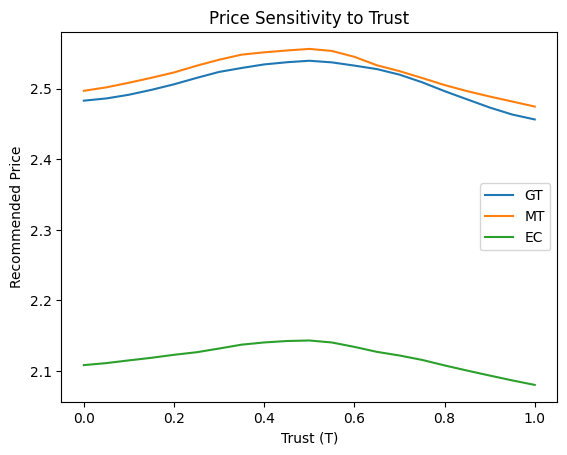

In [ ]:
plt.figure()
plt.plot(out["T"], out["P_GT"], label="GT")
plt.plot(out["T"], out["P_MT"], label="MT")
plt.plot(out["T"], out["P_EC"], label="EC")
plt.xlabel("Trust (T)")
plt.ylabel("Predicted Price")
plt.title("Price Sensitivity to Trust")
plt.legend()
plt.show()



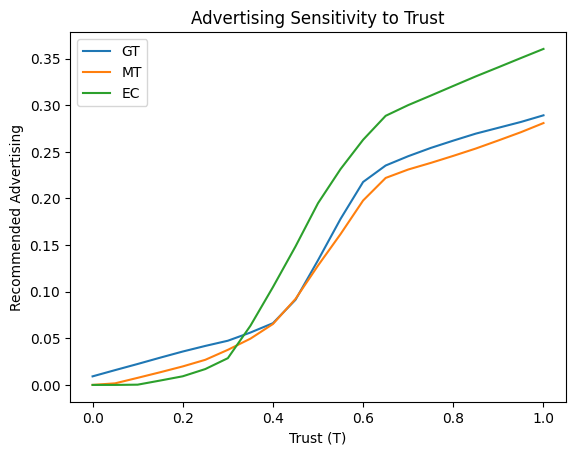

In [ ]:
plt.figure()
plt.plot(out["T"], out["a_GT"], label="GT")
plt.plot(out["T"], out["a_MT"], label="MT")
plt.plot(out["T"], out["a_EC"], label="EC")
plt.xlabel("Trust (T)")
plt.ylabel("Predicted Advertising")
plt.title("Advertising Sensitivity to Trust")
plt.legend()
plt.show()


In [ ]:
# =========================================
# Runtime test: Re-solving equilibrium vs. AI policy inference
# =========================================


# ---- 1) Convert a df row back into (T, params, gamma, sigma) for the solver
def row_to_env_for_solver(row):
    """
    Takes one row from df_test and reconstructs the inputs needed by solve_equilibrium_fast:
    (T, params, gamma, sigma)
    """
    T = float(row["T"])

    # params needed by solve_equilibrium_fast / price_star / ad_best_response
    params = {}
    for key in ["alpha","beta","kappa","psi","chi","p","theta"]:
        params[key] = {ch: float(row[f"{key}_{ch}"]) for ch in channels}

    # costs c_i already stored in df
    params["c"] = {ch: float(row[f"c_{ch}"]) for ch in channels}

    # cross effects
    gamma = {(i,j): float(row[f"gamma_{i}_{j}"]) for i in channels for j in channels if i != j}
    sigma = {(i,j): float(row[f"sigma_{i}_{j}"]) for i in channels for j in channels if i != j}

    return T, params, gamma, sigma


# ---- 2) Timing helper
def time_method_over_states(method, n=1000, warmup=50, seed=123):
    """
    method: function taking index k (0..n-1) and doing one full computation
    returns: dict of mean/median/p95 in milliseconds
    """
    rng_local = np.random.default_rng(seed)
    idxs = rng_local.choice(len(df_test_r), size=min(n, len(df_test_r)), replace=False)

    # warmup (not timed)
    for k in idxs[:min(warmup, len(idxs))]:
        method(k)

    times_ms = []
    for k in idxs:
        t0 = time.perf_counter()
        method(k)
        t1 = time.perf_counter()
        times_ms.append((t1 - t0) * 1000.0)

    times_ms = np.array(times_ms)
    return {
        "n": int(len(times_ms)),
        "mean_ms": float(times_ms.mean()),
        "median_ms": float(np.median(times_ms)),
        "p95_ms": float(np.percentile(times_ms, 95)),
    }


# ---- 3) Prepare test data
df_test_r = df_test.reset_index(drop=True)

X_test_s_local = X_test_s  # Keep the scaled features in cell 2


# ---- 4) Define the two timed methods

    # A) Re-solve equilibrium for each state (baseline)
def method_resolve_equilibrium(k):
    row = df_test_r.iloc[k]
    T, params, gamma, sigma = row_to_env_for_solver(row)
    _P, _a, _Plo, _Phi = solve_equilibrium_fast(T, params, gamma, sigma)
    return _P, _a

    # B) AI inference for each state
def method_ai_policy(k):
    X1 = X_test_s_local[k:k+1]
    df1 = df_test_r.iloc[k:k+1]
    _Y = predict_with_constraints(X1, df1)   # shape (1,6)
    return _Y


# ---- 5) Run timings
solver_stats = time_method_over_states(method_resolve_equilibrium, n=1000, warmup=50)
ai_stats     = time_method_over_states(method_ai_policy,          n=1000, warmup=50)

speedup_mean  = solver_stats["mean_ms"] / max(ai_stats["mean_ms"], 1e-12)
speedup_p95   = solver_stats["p95_ms"]  / max(ai_stats["p95_ms"],  1e-12)

# ---- 6) Output
runtime_table = pd.DataFrame([
    {"Method": "Re-solve near-Nash (solver)", **solver_stats},
    {"Method": "Trained policy (AI)",        **ai_stats},
])
runtime_table["mean_ms"]   = runtime_table["mean_ms"].map(lambda x: f"{x:.3f}")
runtime_table["median_ms"] = runtime_table["median_ms"].map(lambda x: f"{x:.3f}")
runtime_table["p95_ms"]    = runtime_table["p95_ms"].map(lambda x: f"{x:.3f}")

print("\n=== Runtime per state (ms) on test states ===")
display(runtime_table[["Method","n","mean_ms","median_ms","p95_ms"]])

print(f"\nSpeedup (mean latency): {speedup_mean:.1f}×")
print(f"Speedup (p95 latency) : {speedup_p95:.1f}×")



=== Runtime per state (ms) on test states ===


,Method,n,mean_ms,median_ms,p95_ms
0,Re-solve near-Nash (solver),1000,0.614,0.592,0.734
1,Trained policy (AI),1000,0.246,0.238,0.293



Speedup (mean latency): 2.5×
Speedup (p95 latency) : 2.5×


### Step 3: Natural-Language → State Sampler → Policy Recommendation with Narrative

This cell implements a **language-to-policy interface** that maps qualitative inputs to parameter intervals, samples plausible market states, applies the learned policy with constraints, and returns both **numeric summaries** and a **human-readable narrative**.

**Purpose**
- Allow users to specify soft conditions (e.g., `{"trust":"low","substitutability":"high","ad_cost":"high"}`) without numeric estimates.
- Produce **robust action summaries** (median and 5–95% bands) for prices and ads across GT/MT/EC.

**Method**
- Map qualitative levels to numeric intervals (aligned with simulation priors).
- Monte Carlo sample \(M\) states; compute costs \(c_i\) and cross-effects.
- Apply the trained policy with feasibility constraints:
  P_i in [1.05 c_i,6.0 c_i], a_i in [0,20].
- Aggregate predictions by reporting **median**, **p05**, **p95** per channel.
- Optional converts medians/bands into concise recommendations
  (e.g., “moderate pricing,” “light advertising”), optionally reporting markup.

**Reproducibility**
- Fixed seed for sampling (`rng = np.random.default_rng(2025)`).
- Requires variables from the training cell: `channels`, `feature_cols`, `scaler`, `model`, `predict_with_constraints`.

**Outputs**
- `recommend_from_nl(query, M) → Series`: median/p05/p95 for P and a by channel.
- `recommend_with_text(query, M) → (Series, str)`: same summary plus a narrative explanation.

> This interface operationalizes the “bridge”: **economic simulator priors** guide the state sampler, while the **learned policy** delivers instant, interpretable recommendations from natural-language prompts.


In [ ]:
# ========= Natural language -> state sampler -> policy recommendation =========

rng = np.random.default_rng(2025)

# Midpoints matching simulation ranges
MID = {
    "alpha":1.0, "beta":1.0, "kappa":1.0, "psi":0.5, "chi":1.15, "p":4.0, "theta":0.5,
    "w":0.9, "l":0.35, "mu":0.15, "T":0.5, "gamma":0.5, "sigma":0.5
}

# ---- 1) Mapping qualitative levels → numeric intervals (consistent with simulation ranges)
LEVELS = {
    "trust": {"low":(0.10,0.30), "medium":(0.40,0.60), "med":(0.40,0.60), "high":(0.70,0.90)},
    "substitutability": {"low":(0.30,0.40), "medium":(0.45,0.55), "med":(0.45,0.55), "high":(0.60,0.70)},
    "spillover": {"low":(0.30,0.40), "medium":(0.45,0.55), "med":(0.45,0.55), "high":(0.60,0.70)},
    # NOTE: chi ↑ ⇒ ad cost ↓ ; so "ad_cost=high" → low chi
    "ad_cost": {"low":(1.2,1.5), "medium":(1.0,1.2), "med":(1.0,1.2), "high":(0.8,1.0)},
    "logistics": {"low":(0.10,0.20), "medium":(0.30,0.40), "med":(0.30,0.40), "high":(0.50,0.60)},
}

def level_to_interval(key, val):
    if val is None: return None
    v = str(val).lower().strip()
    return LEVELS.get(key, {}).get(v, None)

# ---- 2) Sample M random market states from chosen interval
def sample_from_interval(interval, size=None):
    lo, hi = interval
    return rng.uniform(lo, hi, size=size) if size else float(rng.uniform(lo, hi))

# ---- 3) Prepare feature, target and Apply trained policy in cell 2
def build_feature_df_from_query(query, M=200):
    """
    query: dict like {"trust":"low","substitutability":"high","ad_cost":"high", ...}
    returns: DataFrame with exactly feature_cols in the right order.
    """
    I_T   = level_to_interval("trust",            query.get("trust"))
    I_gam = level_to_interval("substitutability", query.get("substitutability"))
    I_sig = level_to_interval("spillover",        query.get("spillover"))
    I_chi = level_to_interval("ad_cost",          query.get("ad_cost"))
    I_l   = level_to_interval("logistics",        query.get("logistics"))

    rows=[]
    for _ in range(M):
        rec={}
        rec["T"] = sample_from_interval(I_T) if I_T else MID["T"]

        # channel-specific parameters
        for k in ["alpha","beta","kappa","psi","chi","p","theta","w"]:
            for ch in channels:
                rec[f"{k}_{ch}"] = sample_from_interval(I_chi) if (k=="chi" and I_chi) else MID[k]

        # logistics (GT/MT), EC=0
        rec["l_GT"] = sample_from_interval(I_l) if I_l else MID["l"]
        rec["l_MT"] = sample_from_interval(I_l) if I_l else MID["l"]
        rec["l_EC"] = 0.0

        # mu (EC midpoint; GT/MT = 0)
        rec["mu_GT"] = 0.0; rec["mu_MT"] = 0.0; rec["mu_EC"] = MID["mu"]

        # costs c_i
        w_GT, w_MT, w_EC = rec["w_GT"], rec["w_MT"], rec["w_EC"]
        l_GT, l_MT = rec["l_GT"], rec["l_MT"]
        mu_EC = rec["mu_EC"]
        rec["c_GT"] = w_GT + l_GT
        rec["c_MT"] = w_MT + l_MT
        rec["c_EC"] = w_EC / max(1.0 - mu_EC, 1e-6)

        # cross-terms
        for i in channels:
            for j in channels:
                if i==j: continue
                rec[f"gamma_{i}_{j}"] = sample_from_interval(I_gam) if I_gam else MID["gamma"]
                rec[f"sigma_{i}_{j}"] = sample_from_interval(I_sig) if I_sig else MID["sigma"]

        rows.append(rec)

    dfq = pd.DataFrame(rows)

    # ensure complete feature columns and correct order
    missing = [c for c in feature_cols if c not in dfq.columns]
    if missing:
        for c in missing:
            if c=="T": dfq[c]=MID["T"]
            elif any(pre in c for pre in ["alpha_","beta_","kappa_","psi_","chi_","p_","theta_","w_"]):
                dfq[c]=1.0
            elif c.startswith("l_"): dfq[c]=0.0
            elif c.startswith("mu_"): dfq[c]=0.0
            elif c.startswith("c_"):  dfq[c]=1.0
            elif c.startswith("gamma_") or c.startswith("sigma_"): dfq[c]=MID["gamma"]
            else: dfq[c]=0.0
    return dfq[feature_cols]

def recommend_from_nl(query, M=200):
    """
    Returns a pandas Series of median/p05/p95 per channel for P and a.
    """
    dfq = build_feature_df_from_query(query, M=M)
    Xs  = scaler.transform(dfq.values)
    Yp  = predict_with_constraints(Xs, dfq)  # uses function defined in cell 2

    out = {}
    for i, ch in enumerate(channels):
        P_samp, a_samp = Yp[:, i], Yp[:, i+3]
        out[f"P_{ch}_med"]  = np.median(P_samp)
        out[f"P_{ch}_p05"]  = np.percentile(P_samp, 5)
        out[f"P_{ch}_p95"]  = np.percentile(P_samp, 95)
        out[f"a_{ch}_med"]  = np.median(a_samp)
        out[f"a_{ch}_p05"]  = np.percentile(a_samp, 5)
        out[f"a_{ch}_p95"]  = np.percentile(a_samp, 95)
    s = pd.Series(out)
    # keep dfq for downstream narrative if needed
    s._dfq = dfq  # attach as attribute (convenience)
    return s

# ---- 4) Narrative explainer
def _describe_price_by_markup(markup):
    # Simple bands; tweak as you wish
    if markup < 1.15: return "aggressive pricing"
    elif markup < 1.50: return "moderate pricing"
    else: return "high-margin pricing"

def _describe_ad_level(a):
    if a < 0.01: return "no advertising"
    elif a < 0.05: return "light advertising"
    elif a < 0.15: return "moderate advertising"
    else: return "heavy advertising"

def explain_policy_output(series):
    """
    Turn the numeric summary (median + p05/p95) into human-readable text.
    If the source dfq (with costs) is attached, also report markup ≈ P_med / c_med.
    """
    lines = []
    dfq = getattr(series, "_dfq", None)
    c_med = {}
    if dfq is not None:
        for ch in channels:
            c_med[ch] = float(np.median(dfq[f"c_{ch}"]))
    for ch in channels:
        p_med = float(series[f"P_{ch}_med"])
        p05   = float(series[f"P_{ch}_p05"])
        p95   = float(series[f"P_{ch}_p95"])
        a_med = float(series[f"a_{ch}_med"])
        a05   = float(series[f"a_{ch}_p05"])
        a95   = float(series[f"a_{ch}_p95"])

        if dfq is not None:
            mk = p_med / max(c_med[ch], 1e-8)
            price_desc = _describe_price_by_markup(mk)
            price_bit = f"price ≈ {p_med:.2f} [{p05:.2f}, {p95:.2f}] (markup ≈ {mk:.2f}×, {price_desc})"
        else:
            price_desc = _describe_price_by_markup(p_med)  # fallback if no costs
            price_bit = f"price ≈ {p_med:.2f} [{p05:.2f}, {p95:.2f}] ({price_desc})"

        ad_desc = _describe_ad_level(a_med)
        ad_bit  = f"{ad_desc} ≈ {a_med:.3f} [{a05:.3f}, {a95:.3f}]"

        lines.append(f"{ch}: {price_bit}; ads: {ad_bit}.")
    return "\n".join(lines)

def recommend_with_text(query, M=200):
    """
    Convenience: returns (summary_series, narrative_text).
    """
    s = recommend_from_nl(query, M=M)
    text = explain_policy_output(s)
    return s, text

# -------- Example --------
if __name__ == "__main__":
    summary, narrative = recommend_with_text(
        {"trust":"low", "substitutability":"low", "ad_cost":"low"}, M=300
    )
    print(summary)
    print("\n=== Suggested Actions (Narrative) ===")
    print(narrative)

P_GT_med    3.049861
P_GT_p05    2.847400
P_GT_p95    3.272487
a_GT_med    0.030224
a_GT_p05    0.016440
a_GT_p95    0.045971
P_MT_med    3.059474
P_MT_p05    2.888510
P_MT_p95    3.245281
a_MT_med    0.035660
a_MT_p05    0.014990
a_MT_p95    0.059419
P_EC_med    2.579957
P_EC_p05    2.442106
P_EC_p95    2.779089
a_EC_med    0.029097
a_EC_p05    0.000000
a_EC_p95    0.066720
dtype: float64

=== Suggested Actions (Narrative) ===
GT: price ≈ 3.05 [2.85, 3.27] (markup ≈ 2.44×, high-margin pricing); ads: light advertising ≈ 0.030 [0.016, 0.046].
MT: price ≈ 3.06 [2.89, 3.25] (markup ≈ 2.45×, high-margin pricing); ads: light advertising ≈ 0.036 [0.015, 0.059].
EC: price ≈ 2.58 [2.44, 2.78] (markup ≈ 2.44×, high-margin pricing); ads: light advertising ≈ 0.029 [0.000, 0.067].


In [ ]:
# =========================================
# Optional: Runtime scaling with M for natural-language queries
# Compare: solving M equilibria vs running M AI predictions
# =========================================


def time_nl_M(M=100, warmup=1):
    # Build M states from NL query function
    dfq = build_feature_df_from_query({"trust":"low", "ad_cost":"high"}, M=M)
    Xs  = scaler.transform(dfq.values)

    # Warmup
    for _ in range(warmup):
        _ = predict_with_constraints(Xs[:1], dfq.iloc[:1])

    # 1) AI time: M forward passes (batched)
    t0 = time.perf_counter()
    _ = predict_with_constraints(Xs, dfq)
    t1 = time.perf_counter()
    ai_ms = (t1 - t0) * 1000.0

    # 2) Solver time: solve M equilibria by converting each row into env and solving
    t0 = time.perf_counter()
    for r in range(M):
        row = dfq.iloc[r]
        # reconstruct env in the same format your solver expects
        # NOTE: dfq already has the same fields as feature_cols, including gamma/sigma and costs
        T, params, gamma, sigma = row_to_env_for_solver(row)
        _ = solve_equilibrium_fast(T, params, gamma, sigma)
    t1 = time.perf_counter()
    solver_ms = (t1 - t0) * 1000.0

    return {"M": M, "AI_total_ms": ai_ms, "Solver_total_ms": solver_ms,
            "Speedup": solver_ms / max(ai_ms, 1e-12)}

rows = [time_nl_M(M) for M in [10, 100, 1000]]
tbl = pd.DataFrame(rows)
tbl["AI_total_ms"] = tbl["AI_total_ms"].map(lambda x: f"{x:.2f}")
tbl["Solver_total_ms"] = tbl["Solver_total_ms"].map(lambda x: f"{x:.2f}")
tbl["Speedup"] = tbl["Speedup"].map(lambda x: f"{x:.1f}×")

print("\n=== Runtime scaling for NL sampling (total time) ===")
display(tbl)



=== Runtime scaling for NL sampling (total time) ===


,M,AI_total_ms,Solver_total_ms,Speedup
0,10,7.83,17.71,2.3×
1,100,72.44,333.21,4.6×
2,1000,108.96,1610.69,14.8×
